In [1]:
import Pkg; Pkg.add("MLDatasets")
Pkg.add("CUDA")
using Printf, Random, Test, Statistics
using MLDatasets
using Knet
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
import CUDA # functional
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
using Knet: Knet, dir, accuracy, progress, sgd, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout, sigm # param, param0, xavier_uniform
#using IterTools: ncycle, takenth
#using Base.Iterators: flatten
using JLD2, FileIO

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `/scratch/users/ashah20/.julia/environments/v1.5/Project.toml`
No Changes to `/scratch/users/ashah20/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `/scratch/users/ashah20/.julia/environments/v1.5/Project.toml`
No Changes to `/scratch/users/ashah20/.julia/environments/v1.5/Manifest.toml`


In [2]:
# load full training set
train_x, train_y = CIFAR10.traindata()

# load full test set
test_x,  test_y  = CIFAR10.testdata()

size(train_x), size(train_y), size(test_x), size(test_y)

((32, 32, 3, 50000), (50000,), (32, 32, 3, 10000), (10000,))

In [3]:
CUDA.reclaim()
CUDA.memory_status()

Effective GPU memory usage: 0.95% (308.750 MiB/31.749 GiB)
CUDA allocator usage: 0 bytes
binned usage: 0 bytes (0 bytes allocated, 0 bytes cached)


In [4]:
"""
    occlude(image, n_rows)

Creates occluded image by assigning zeros to image rows - n_rows
"""
function occlude(image, n_rows)
    i_size = size(image)
    zero = zeros(i_size[1]-n_rows, i_size[2], i_size[3])
    occluded = vcat(image[1:n_rows,:,:], zero)
    return occluded
end

function occlude_data(data, n_rows)
    i_size = size(data)
    zero = zeros(i_size[1]-n_rows, i_size[2], i_size[3])
    occluded_data = vcat(data[1:n_rows,:,:], zero)
    return occluded_data
end

function discretize(data)
    data = data .* 255
    data = ceil.(data)
end


discretize (generic function with 1 method)

In [5]:
struct ConvA
    w
    b
    f
    p 
end

function (c::ConvA)(x)
    return c.f.(conv4(c.w, dropout(x,c.p), padding = 0) .+ c.b)
end

function ConvA(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0)
    atype=KnetArray{Float32}
    w = (atype(ones(w1,w2,cx,cy)))
    w[5:7,:,:,:] .= 0
    w[4,4:7,:,:] .= 0
    w = Param(w)
    return ConvA(w, param0(1,1,cy,1, atype=KnetArray{Float32}), f, pdrop)
end


ConvA

In [6]:
# Define a convolutional layer:

struct ConvB
    w
    b
    f
    p
    pad
end

function (c::ConvB)(x)
    return c.f.(conv4(c.w, dropout(x,c.p), padding = c.pad) .+ c.b)
end

function ConvB(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0, pad=1)
    return ConvB(param(w1,w2,cx,cy, atype=KnetArray{Float32}), param0(1,1,cy,1, atype=KnetArray{Float32}), f, pdrop, pad)
end


ConvB

In [7]:
struct ResBlock
    convlayers
    ResBlock(convlayers...) = new(convlayers)
end

function (res::ResBlock)(x)
    xres = copy(x)
    
    for l in res.convlayers
        x = l(x)
    end
   
    return x .+ xres
end


In [8]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [9]:
function padImage(image, padding=1, constant=0)
    row, col, chnl = size(image)
    pad1 = ones(padding, col, chnl) .* constant
    pad2 = ones(padding*2+row, padding, chnl) .* constant
    padded = vcat(pad1, image, pad1)
    padded = hcat(pad2, padded, pad2)
    return padded
end

function pad(data, padding=1, constant=0)
    row, col, chnl, dsize = size(data)
    padded = zeros(row+padding*2, col+padding*2, chnl, dsize)
    for i in 1:dsize
        padded[:,:,:,i] .= padImage(data[:,:,:,i], padding, constant)
    end
    return padded
end

pad (generic function with 3 methods)

In [10]:
atype=KnetArray{Float32}
small_data = train_x[:,:,:,1:50000];
disc_data = discretize(small_data)
small_data = pad(small_data, 3, 0.01)
small_data = atype(small_data);

lbls = reshape(disc_data[:,:,:,1:50000], (3072,50000));
lbls = Int64.(lbls);

In [11]:
size(small_data)

(38, 38, 3, 50000)

In [12]:
function lossfunc(model, images, lbls)
    loss = 0.0
    score = model(images)
    #println(sum.(score))
    scores = reshape(score, (3072,256, :));
    #println(score)

    for i in 1:50
        loss += nll(scores[:,:,i], lbls[:,i], dims=2)
    end

    return loss /= 50
    
end

lossfunc (generic function with 1 method)

In [13]:
function trainmodel(model, images, lbls)
    L = @diff lossfunc(model, images, lbls)
    
    for p in params(model)
        g = grad(L, p)
        update!(value(p), g, p.opt)
    end
    #println(value(L))
    return value(L)
end

trainmodel (generic function with 1 method)

In [14]:
Random.seed!(1)

d = 128

residual = ResBlock(ConvB(1,1,256,128, pad=0),
                    ConvB(1,1,128,128, pad=0),
                    ConvB(1,1,128,256, pad=0))


model_rand =   Chain(residual,
                ConvB(1,1,256,d, pad=0),
                ConvB(1,1,d,256*3, pad=0))


atype=KnetArray{Float32}
w = randn(7,7,3,256)
w[5:7,:,:,:] .= 0
w[4,4:7,:,:] .= 0
w = atype(w);


In [15]:
losses = zeros(1, 100)
batchsize = 50


for p in params(model_rand)
    p.opt = Adagrad(lr=0.01, gclip=0.01)
end

batchloss = 0

for epochs in 1:100
    for batch in 1:1000
        batch_data = small_data[:,:,:,((batch-1)*batchsize+1):batch*batchsize]
        batch_data = conv4(w, batch_data)
        batchloss = trainmodel(model_rand, batch_data, lbls[:,((batch-1)*batchsize+1):batch*batchsize])
        #println(batchloss)
    end
    losses[epochs] = batchloss
    println(losses[epochs])
end

4.995827369689941
4.815089569091797
4.701465392112732
4.614110507965088
4.556533675193787
4.512005624771118
4.472695188522339
4.442428603172302
4.409692540168762
4.381155681610108
4.357384762763977
4.330796771049499
4.311597943305969
4.297767415046692
4.285689067840576
4.274761624336243
4.260611038208008
4.251335849761963
4.242707185745239
4.23476749420166
4.226480565071106
4.218574290275574
4.212095146179199
4.206090435981751
4.200169939994812
4.194990229606629
4.188476486206055
4.183289675712586
4.178310842514038
4.173879523277282
4.16938437461853
4.165261840820312
4.161410584449768
4.156686763763428
4.150882077217102
4.147193694114685
4.141731071472168
4.138269920349121
4.134956769943237
4.131841034889221
4.128732213973999
4.125838809013366
4.123077101707459
4.120409803390503
4.117861776351929
4.115471148490906
4.112006640434265
4.109522671699524
4.107081680297852
4.103103303909302
4.1007937240600585
4.098772296905517
4.096733956336975
4.0947759294509884
4.092955646514892
4.09119321

In [ ]:
params(model_rand)

In [ ]:
@save "modelCNN3.jld2" model

In [ ]:
@save "modelCNN_Cifar.jld2" model_rand w

In [ ]:
@load "modelCNN_Cifar.jld2" model_rand w

In [ ]:
tst_data = small_data[:,:,:,1:10]
tst_data = conv4(w, tst_data)
score = model(tst_data);

In [18]:
using PyPlot

In [ ]:
scores = reshape(score, (3072,256, 10))
predicted = argmax(scores[:,:,1], dims=2)
pred_image = zeros(3072,1)
for i in 1:3072
    pred_image[i] = predicted[i][2]
end

image = reshape(pred_image, (32,32,3));
sample = image ./ 256;
B = Array{Float32}(sample);
#subplot(1,3,2)
matshow(B)

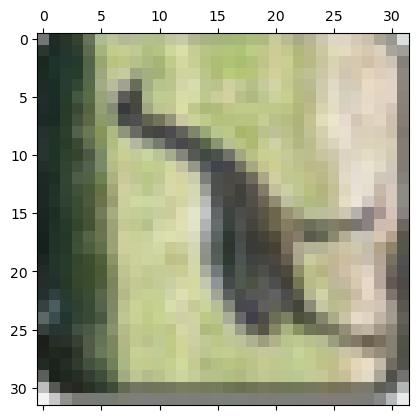

PyObject <matplotlib.image.AxesImage object at 0x2b294f441220>

In [19]:
matshow(train_x[:,:,:,2292])

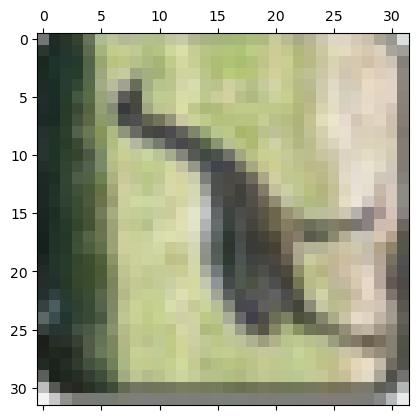

In [32]:
an_image = train_x[:,:,:,2292]
n_rows = 16
#an_image = occlude(an_image, n_rows)
matshow(an_image)
#test_image = reshape(test_image, (32,32,3,1))
#test_image = pad(test_image, 3, 1)
#test_image = atype(test_image);

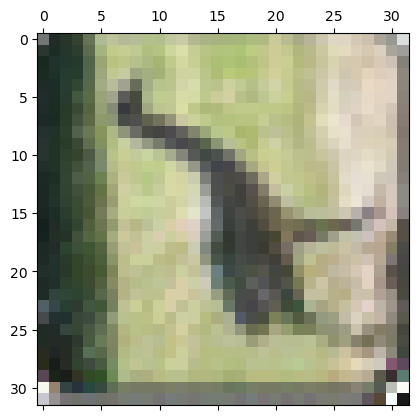

PyObject <matplotlib.image.AxesImage object at 0x2b2a9ed627f0>

In [37]:
#orig_image = copy(test_x[:,:,:,42])
new_image = zeros(size(an_image))
orig_image = copy(an_image)
orig_image = reshape(orig_image, (32,32,3,1))
for j in n_rows+1:32
    for k in 1:32
        test_image = pad(orig_image, 3, 0.1)
        test_image = atype(test_image);
        test_image = conv4(w, test_image)
        score = model_rand(test_image)
        scores = reshape(score, (3072,256, 1));
        predicted = argmax(scores, dims=2)
        pred_image = zeros(3072,1)
        for i in 1:3072
            pred_image[i] = predicted[i][2]
        end
        image = reshape(pred_image, (32,32,3));
        sample = image ./ 256;
        B = KnetArray{Float32}(sample);
        #println(B[j,k,:])
        orig_image[j,k,:,:] .= B[j,k,:]
        new_image[j,k,:,:] .= B[j,k,:]
        
    end
end
image = reshape(orig_image, (32,32,3));
matshow(image)

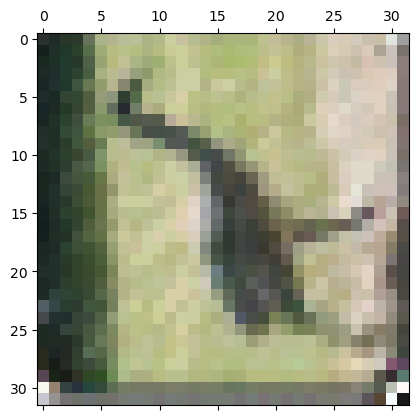

PyObject <matplotlib.image.AxesImage object at 0x2b2a9e766400>

In [36]:
matshow(new_image)

In [ ]:
matshow(test_x[:,:,:,42])